# **The Stokes equations - adaptive mesh refinement**
**Johan Hoffman**

# **Abstract**

In this report I use FEniCS to solve the Stokes equations using adaptive mesh refinement by formulating and solving the adjoint problem for a given functional and investigate the adjoint solution as well as the obtained mesh refinement. The domain is rectangular with in and outflow at the left- and right boundary and walls for the rest and a cylinder somwhere within the domain. I use the drag and lift forces as functionals and look at the mesh refinement for different positions of the cylinder. The mesh refinement generally coincides with the regions where the adjoint problem has a large velocity gradient and high or low pressure.

# **About the code**

In [ ]:
"""This program is an example file for the course"""
"""DD2365 Advanced Computation in Fluid Mechanics, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2020 Johan Hoffman (jhoffman@kth.se)

# This file is part of the course DD2365 Advanced Computation in Fluid Mechanics
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This template is maintained by Johan Hoffman
# Please report problems to jhoffman@kth.se

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

In [ ]:
# Load neccessary modules.
from google.colab import files

import numpy as np
import time

# Install FEniCS (this may take a long time)
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin
    
from dolfin import *; from mshr import *

import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt

--2022-04-23 15:08:44--  https://fem-on-colab.github.io/releases/fenics-install.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.110.153, 185.199.111.153, 185.199.109.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.110.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2831 (2.8K) [application/x-sh]
Saving to: ‘/tmp/fenics-install.sh’

/tmp/fenics-install 100%[===================>]   2.76K  --.-KB/s    in 0s      

2022-04-23 15:08:44 (29.4 MB/s) - ‘/tmp/fenics-install.sh’ saved [2831/2831]

+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ FENICS_INSTALLED=/usr/local/share/fem-on-colab/fenics.installed
+ [[ ! -f /usr/local/share/fem-on-colab/fenics.installed ]]
+ PYBIND11_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/e9e1ba9/releases/pybind11-install.sh
+ [[ https://github.com/fem-on-colab/fem-on-colab.github.io/raw/e9e1ba9/releases/pybind11-install.sh == http* ]]
+ PYBIND11_

# **Introduction**

The Stokes equations take the form

$\nabla p -\Delta u = f,\quad \nabla \cdot u=0,$

together with boundary conditions for $\partial \Omega = \Gamma_D \cup \Gamma_N \cup \Gamma_F$

$
u=g_D,\quad x\in \Gamma_D
$

$
u=0,\quad x\in \Gamma_F
$

$
-\nabla u\cdot n + pn = 0,\quad x\in \Gamma_N
$

Here $\Gamma_D$ is the part of the boundary where we prescribe Dirichlet boundary conditions, $\Gamma_N$ a part of the boundary where we apply a homogeneous Neumann boundary condition, and $\Gamma_F$ the part of the boundary over which we want to compute the force. 

The weak (variational) form of the equations is: find a solution $(u,p)\in V\times Q$ such that 

$- (p,\nabla \cdot v) + (\nabla u,\nabla v) + (\nabla \cdot u, q) = (f,v)$

for all test functions $(v,q) \in \hat V \times Q$, where $\hat V$ are the test functions $v$ such that $v=0$ for $x\in \Gamma_D$.

Here we present a FEniCS implementation of a mixed finite element method to solve the Stokes equations in 2D. The solution is visualized using FEniCS plotting functions, and is also exported as pvd-files which can be visualized in Paraview.

We seek a finite element approximation $(U,P)\in V_h\times Q_h$ such that 

$- (P,\nabla \cdot v) + (\nabla U,\nabla v) + (\nabla \cdot U, q) = (f,v)$

for all test functions $(v,q) \in \hat V_h \times Q_h$, where $\hat V_h$ are the test functions $v$ such that $v=0$ for $x\in \Gamma_D$. Here $V_h\subset V, Q_h\subset Q, \hat V_h\subset \hat V$ are finite dimensional subspaces defined over the computational mesh by finite element basis functions. 

To implement the velocity Dirichlet boundary conditions we use a penalty formulation, with a penalty parameter $\gamma = C/h$, where $C>0$ is a constant and $h$ is the local mesh size. At the outflow a "do nothing" zero stress boundary condition is used, meaning that the boundary condition is enforced weakly by setting the boundary integral to zero. 

We consider the linear functional $F:V\times Q\rightarrow {\mathbb R}$, 

$F(v,q) = (v,\psi_1)_{\Omega} + (q,\psi_2)_{\Omega} + \left<\nabla v\cdot n - pn,\psi_3 \right>_{\Gamma_F}$

corresponding to weighted mean values of $v$ and $q$, and the force on the surface $\Gamma_F\subset \partial \Omega$, 
which generates the adjoint Stokes equations

$-\nabla \theta -\Delta \varphi = \psi_1,\quad -\nabla \cdot \varphi=\psi_2,$

together with boundary conditions that reflect the primal equations and the chosen functional. 

$
\varphi=0,\quad x\in \Gamma_D
$

$
\varphi=\psi_3,\quad x\in \Gamma_F
$

$
- \nabla \varphi \cdot n - \theta n=0, \quad x\in \Gamma_N
$

The weak form of the adjoint Stokes equations take the form: find $(\varphi,\theta)\in \hat V\times Q$ such that 

$- (q,\nabla \cdot \varphi) + (\nabla v,\nabla \varphi) + (\nabla \cdot v, \theta) = (v,\psi_1)_{\Omega} + (q,\psi_2)_{\Omega} - \left<\nabla v\cdot n - pn,\psi_3 \right>_{\Gamma_F}= F(v,q)$

for all test functions $(v,q) \in V\times Q$. 

Since the Stokes equations are linear we can express the error in the linear functional with respect to an approximation $(u,p)\approx (U,P)$ as

$F(u,p) - F(U,P) = (f,\varphi) + (P,\nabla \cdot \varphi) - (\nabla U,\nabla \varphi) - (\nabla \cdot U, \theta) = r(U,P;\varphi,\theta) = \sum_K {\mathcal E}_K$

where we used that $F(u,p)=(f,\varphi)$ since $\varphi \in \hat V$, 
with the error indicator 

${\mathcal E}_K = r(U,P;\varphi,\theta)\vert _K$, 

which is the local residual on weak form with the solution to the adjoint equation as test function. The error indicator ${\mathcal E}_K$ can be used as an indicator for where to refine the mesh to reduce the global error as efficiently as possible. 

Note however that since $(U,P)\in V\times Q$ is the solution of a Galerkin finite element method, if we use the approximation $(\varphi,\theta) \approx (\varphi_h,\theta_h) \in \hat V_h\times Q_h$, the error indicators sum to zero. Hence, this sum cannot be used as a stopping criterion for an adaptive algorithm. Instead we may use error estimates of the type 

$
{\mathcal E}_K \leq C h_K  (\Vert \nabla \varphi_h \Vert_K + \Vert \nabla \theta_h\Vert_K) \Vert R(U,P)\Vert_K
$

where $R(U,P)=(R_1(U,P),R_2(U))$ is the residual of the equations in strong form, with 

$
R_1(U,P) = f + \Delta U - \nabla P
$

$
R_2(U) = \nabla \cdot U
$

To read more about how to use similar methods for more complex problems, see e.g.

[Hoffman, Johan, et al. "Towards a parameter-free method for high reynolds number turbulent flow simulation based on adaptive finite element approximation." Computer Methods in Applied Mechanics and Engineering 288 (2015): 60-74.](https://www.sciencedirect.com/science/article/pii/S0045782514004836)

**Research question**
Here, I use FeniCs to solve the Stokes equations in a rectangular domain as well as the adojoint problem in order to assess where the mesh could be refined in order to improve the accuracy. Specifically, I investegate how the adjoint solution and in turn the mesh refinment change as the cylinder is moved across the domain and as the data for the adjoint problem is changed?


# **Method**

In this lab I solve Stokes equations in a rectangular domain with a cylinder inside. It is done using a uniform mesh. The boundaries are inflow on the left, outflow on the right and walls for the top and bottom. The approximation spaces are of second order for the velocity and first order for the pressure.

I move the cylinder around in the domain and for one plot I change the adjoint problem such that the mesh refinement is suited for calculating the lift force rather than the drag force.


**Computations**

rm: cannot remove 'results-NS/*': No such file or directory


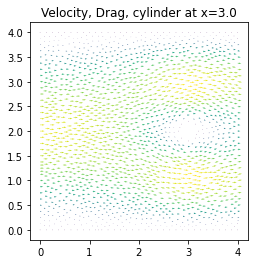

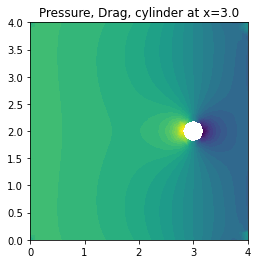

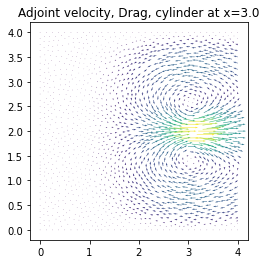

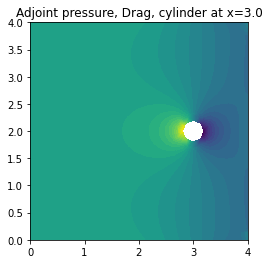

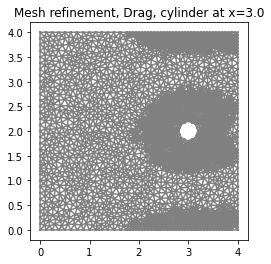

Total error = -0.0009228499490236004
rm: cannot remove 'results-NS/*': No such file or directory


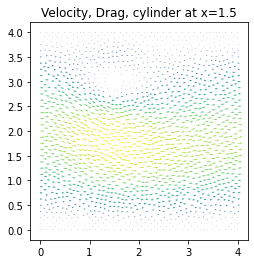

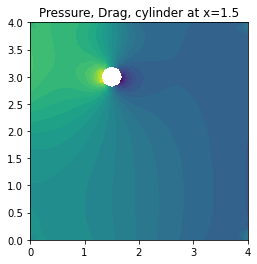

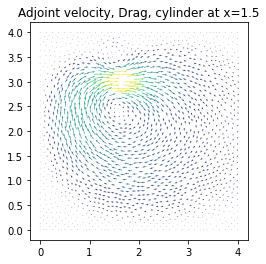

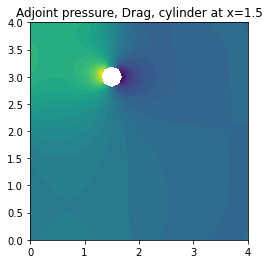

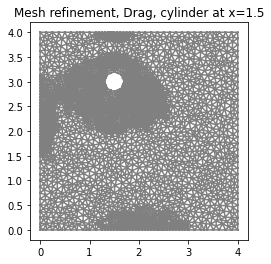

Total error = 0.003259317935636823
rm: cannot remove 'results-NS/*': No such file or directory


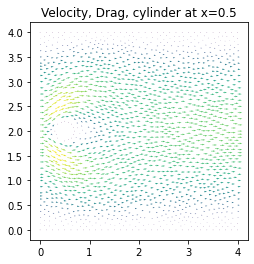

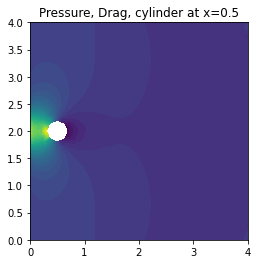

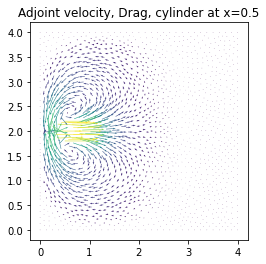

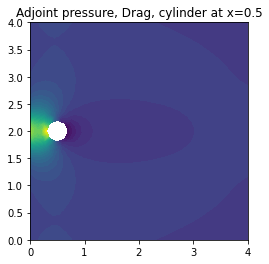

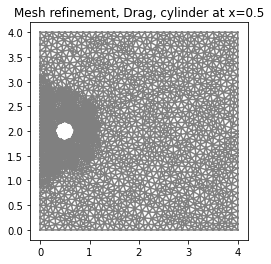

Total error = 0.05062224494773949
rm: cannot remove 'results-NS/*': No such file or directory


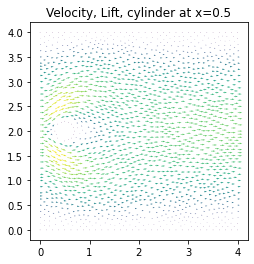

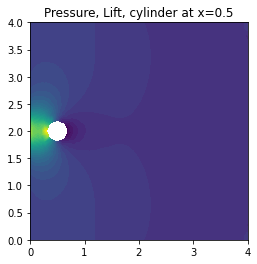

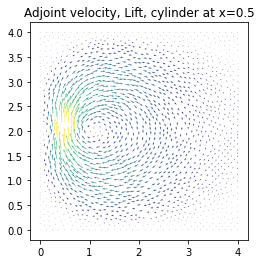

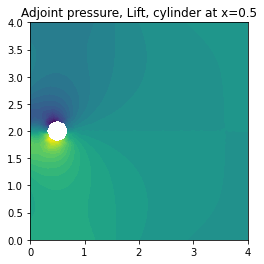

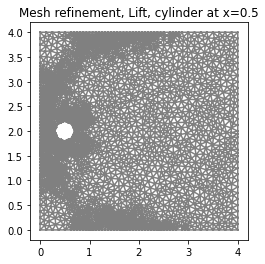

Total error = -0.005230059964786644


In [ ]:
# Define rectangular domain 
L = 4
H = 4

confs = [2.5, 1, 0, 0]
for ind, xy in enumerate(confs):


  # Define circle
  xc = 0.5 + xy
  yc = 0.5*H
  rc = 0.2
  if xy == 1:
    yc = 3


  # Generate mesh (examples with and without a hole in the mesh) 
  resolution = 32
  #mesh = RectangleMesh(Point(0.0, 0.0), Point(L, H), L*resolution, H*resolution)
  mesh = generate_mesh(Rectangle(Point(0.0,0.0), Point(L,H)) - Circle(Point(xc,yc),rc), resolution)

  # Local mesh refinement (specified by a cell marker)
  init_no_levels = 0
  for i in range(0,init_no_levels):
    cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
    for cell in cells(mesh):
      cell_marker[cell] = False
      p = cell.midpoint()
      if p.distance(Point(0.5, 0.5)) < 1.0:
          cell_marker[cell] = True
    mesh = refine(mesh, cell_marker)

  #plt.figure()
  #plot(mesh)
  #plt.show()

  # Generate mixed finite element spaces (for primal velocity and pressure)
  VE = VectorElement("CG", mesh.ufl_cell(), 2)
  QE = FiniteElement("CG", mesh.ufl_cell(), 1)
  WE = VE * QE

  W = FunctionSpace(mesh, WE)
  V = FunctionSpace(mesh, VE)
  Q = FunctionSpace(mesh, QE)

  # Define trial and test functions
  w = Function(W)
  (u, p) = (as_vector((w[0],w[1])), w[2])
  (v, q) = TestFunctions(W) 

  # Generate mixed finite element spaces (for adjoint velocity and pressure)
  VEa = VectorElement("CG", mesh.ufl_cell(), 3)
  QEa = FiniteElement("CG", mesh.ufl_cell(), 2)
  WEa = VEa * QEa

  Wa = FunctionSpace(mesh, WEa)
  Va = FunctionSpace(mesh, VEa)
  Qa = FunctionSpace(mesh, QEa)

  # Define adjoint trial and test functions
  wa = Function(Wa)
  (phi, theta) = (as_vector((wa[0],wa[1])), wa[2])
  (va, qa) = TestFunctions(Wa)

  # Examples of inflow and outflow conditions
  XMIN = 0.0; XMAX = L
  YMIN = 0.0; YMAX = H
  uin = Expression(("4*(x[1]*(YMAX-x[1]))/(YMAX*YMAX)", "0."), YMAX=YMAX, element = V.ufl_element()) 
  #pout = 0.0

  # Inflow boundary (ib), outflow boundary (ob), body boundary (bb) and wall boundary (wb)
  ib = Expression("near(x[0],XMIN) ? 1. : 0.", XMIN=XMIN, element = Q.ufl_element())
  ob = Expression("near(x[0],XMAX) ? 1. : 0.", XMAX=XMAX, element = Q.ufl_element()) 
  wb = Expression("near(x[1],YMIN) || near(x[1],YMAX) ? 1. : 0.", YMIN=YMIN, YMAX=YMAX, element = Q.ufl_element())
  bb = Expression("x[0] > XMIN + DOLFIN_EPS && x[0] < XMAX - DOLFIN_EPS && x[1] > YMIN + DOLFIN_EPS && x[1] < YMAX - DOLFIN_EPS ? 1. : 0.", XMIN=XMIN, XMAX=XMAX, YMIN=YMIN, YMAX=YMAX, element = Q.ufl_element())

  # Set boundary penalty parameter gamma 
  h = CellDiameter(mesh)
  C = 1.0e3
  gamma = C/h

  # Set force in primal problem
  f = Expression(("0.0","0.0"), element = V.ufl_element())

  # Set data that describe functional that defines the adjoint problem
  #psi1 = Expression(("exp(-10.0*(pow(x[0]-2.0,2) + pow(x[1]-1.5,2)))","0.0"), element = V.ufl_element())
  #psi2 = Expression("exp(-10.0(pow(x[0]-2.0,2) + pow(x[1]-1.0,2)))", element = Q.ufl_element())
  psi1 = Expression(("0.0","0.0"), element = V.ufl_element())
  psi2 = Expression("0.0", element = Q.ufl_element())
  phi3 = Expression(("1.0","0.0"), element = V.ufl_element())

  if ind == 3:
    phi3 = Expression(("0.0","1.0"), element = V.ufl_element())
    #psi3 = Expression(("0.0","0.0"), element = V.ufl_element())

  # Define primal variational problem on residual form: r(u,p;v,q) = 0
  res = ( -p*div(v)*dx + inner(grad(u), grad(v))*dx + div(u)*q*dx - inner(f, v)*dx + 
          gamma*(ib*inner(u - uin, v) + wb*inner(u, v) + bb*inner(u, v))*ds )

  # Solve primal algebraic system 
  solve(res == 0, w) 

  # Define adjoint variational problem on residual form: r(u,p;v,q) = 0
  res_a = ( -qa*div(phi)*dx + inner(grad(va), grad(phi))*dx + div(va)*theta*dx + 
            gamma*(ib*inner(phi, va) + wb*inner(phi, va) + bb*inner(phi - phi3, va))*ds 
          - inner(va, psi1)*dx - qa*psi2*dx )

  # Solve adjoint algebraic system 
  solve(res_a == 0, wa) 

  !rm results-NS/*

  # Open files to export solution to Paraview
  file_u = File("results-Stokes/u.pvd")
  file_p = File("results-Etokes/p.pvd")
  file_phi = File("results-Stokes/phi.pvd")
  file_theta = File("results-Etokes/theta.pvd")

  # Initiate functions to save and visualize the solutions
  u_fcn = project(u, V)
  p_fcn = project(p, Q)
  phi_fcn = project(phi, V)
  theta_fcn = project(theta, Q)

  # Save solution to file
  file_u << u_fcn
  file_p << p_fcn
  file_phi << phi_fcn
  file_theta << theta_fcn

  # Plot solution
  if ind == 3:
    plt.figure()
    plot(u_fcn, title="Velocity, Lift, cylinder at x=%s" % str(0.5+xy))

    plt.figure()
    plot(p_fcn, title="Pressure, Lift, cylinder at x=%s" % str(0.5+xy))

    plt.figure()
    plot(phi_fcn, title="Adjoint velocity, Lift, cylinder at x=%s" % str(0.5+xy))

    plt.figure()
    plot(theta_fcn, title="Adjoint pressure, Lift, cylinder at x=%s" % str(0.5+xy))
  else:
    plt.figure()
    plot(u_fcn, title="Velocity, Drag, cylinder at x=%s" % str(0.5+xy))

    plt.figure()
    plot(p_fcn, title="Pressure, Drag, cylinder at x=%s" % str(0.5+xy))

    plt.figure()
    plot(phi_fcn, title="Adjoint velocity, Drag, cylinder at x=%s" % str(0.5+xy))

    plt.figure()
    plot(theta_fcn, title="Adjoint pressure, Drag, cylinder at x=%s" % str(0.5+xy))
            
  plt.show()

  # Export files
  #!tar -czvf results-Stokes.tar.gz results-NS
  #files.download('results-Stokes.tar.gz')

  # Define function space over the elements of the mesh
  WDG = FunctionSpace(W.mesh(), "DG", 0)
  elm = TestFunction(WDG)
  err_ind = Function(WDG)

  # Compute local error indicators over the cells of the mesh 
  local_error = ( elm*inner(f, phi)*dx + elm*p*div(phi)*dx - elm*inner(grad(u), grad(phi))*dx - elm*div(u)*theta*dx ) 
  err_ind.vector()[:] = assemble(local_error)
  err_ind_abs = np.abs(err_ind.vector())
  err_ind_mean = err_ind_abs.sum()/err_ind.vector().size()

  # Local mesh refinement (specified by a cell marker)
  no_levels = 1
  for i in range(0,no_levels):
    cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
    for c in cells(mesh):
      cell_marker[c] = False
      local_error_cell = err_ind_abs[c.index()] 
      if local_error_cell > err_ind_mean:
          cell_marker[c] = True
    mesh = refine(mesh, cell_marker)

  if ind == 3:
    plt.figure()
    plot(mesh, title="Mesh refinement, Lift, cylinder at x=%s" % str(0.5+xy))
  else:
    plt.figure()
    plot(mesh, title="Mesh refinement, Drag, cylinder at x=%s" % str(0.5+xy))
  plt.show()

  err_ind_sum = ( inner(f, phi)*dx + p*div(phi)*dx - inner(grad(u), grad(phi))*dx - div(u)*theta*dx - 
                gamma*(ib*inner(u - uin, phi) + wb*inner(u, phi) + bb*inner(u, phi))*ds )

  tot_err = assemble(err_ind_sum)
  s = 'Total error = ' + repr(tot_err) 
  print(s)

# **Results**

# **Discussion**

A adaptive finite element method was implemented in FEniCS to solve the Stokes equations in 2D. An adjoint problem was defined with respect to a chosen linear functional, after which the residual and the solution to the adjoint was used to define an error indicator over the mesh.

For x = 3 and with the drag force functional we can see that the adjoint solution has high velocity around the cylinder up to the boundaries and then quickly goes to zero at the wall boundaries. The mesh refinement plot for x = 3 also shows that the most important parts of the mesh to refine is close to the cyliner as well as close to the wall boundaries next to it. This is reasonable since the gradient would be very large around the cylinder where the flow sees a lot of interference. The same goes for the wall boundaries as the velocity quickly goes to zero there.

For x = 1.5 I also moved the cylinder closer to the upper wall boundary. The fluid now mostly flows under the cylinder as opposed to around it as can be seen in the velocity plot for x = 1.5. Just as for x = 3, the mesh is refined around the cylinder as well as at the wall boundaries close to it but this time the regions are skewed downwards likely because there's where most of the flow goes.

Looking at x = 0.5 (Drag version) we can see that the adjoint problem looks similar to the one for x = 3 but the center is moved with the cylinder. The mesh refinement is the largest around the cylinder but there is no refinement at the wall boundaries. This is likely because the cylinder is close enough to the inflow far away from the walls that the boundary effects don't influence the region around the cylinder considerably. The boundaries will become more important further downstream.

For the final set of figures, the lift ones with x = 0.5, we can see that the adjoint pressure is the largest and lowest underneath and above the cylinder as opposed to in front and behind it. This is because the pressure is more important to the sides of the cylinder when measuring drag but when measuring lift it is more important to look above and underneath. The mesh refinement looks similar to that of the drag force ones for x = 0.5 but it does not extend as far back and the regions above and below including the boundaries become more important. This seems reasonable since these regions should affect the lift force more than the drag force.